# Battery Suggestions

The presented code performs an analysis of electricity consumption in relation to prices during different time periods of the day. It reads consumption and price data from input files, calculates average consumption and price per hour on weekdays, and generates plots to visualize the trends. The code identifies peak positive and negative consumption hours, filters the data accordingly, and calculates statistics such as average, minimum, and maximum consumption and prices during peak and off-peak hours. It determines the longest sequence of consecutive hours with high prices and calculates the total consumption within that sequence. The code then rounds the total consumption, average and extreme prices, and suggests the ideal battery size based on the highest price sequence.

#### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import holidays

### File paths

It is necessary for the user to input the file path of the consumption data.

**IMPORTANT**

The consumption data file must have at least the following columns:

- Datetime
- Consumption
- Operating Hours

In [2]:
# Consumption Data
#consumption_data = input("Enter the consumption data file path (CSV): ")
consumption_data = 'C:/Users/Diego Galdino/Desktop/New folder/Consumption2.xlsx'

# Price Data
price_Entosoe = 'C:/Users/Diego Galdino/OneDrive - Groene Cadans B.V/Algorithms/Energy-Price-ENTSOE/EntsoeEnergyPrice.csv'
price_Easy = 'C:/Users/Diego Galdino/OneDrive - Groene Cadans B.V/Algorithms/Energy-Price-Easy/EasyEnergyPrice.csv'

#### Choose the Price data

Input number 1 for use the Easy Data or 2 for the Entsoe Data.

In [3]:
# Read consumption data
df_consumption = pd.read_excel(consumption_data)

while True:
    # Select price source
    price_source = input("Select the price source:\n1 - Easy\n2 - Entsoe\n")

    # Read price data based on the selected source
    if price_source == "1":
        df_price = pd.read_csv(price_Easy)
        break
    elif price_source == "2":
        df_price = pd.read_csv(price_Entosoe)
        break
    else:
        print("Invalid selection. Try again.")

# Restrict to required columns
required_columns = ['Datetime', 'Consumption', 'Operating Hours']
df_consumption = df_consumption[required_columns]

# Check if the required columns are present
missing_columns = set(required_columns) - set(df_consumption.columns)
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

Select the price source:
1 - Easy
2 - Entsoe
2


## Consumption Analysis

### Energy Profile Graph (Monday to Friday)

In [4]:
# Create a DataFrame copy for NOT change the originial
data_C = df_consumption.copy()

# Group by weekday
data_C['Weekday'] = data_C['Datetime'].dt.weekday

# Calculate average consumption per hour from Monday to Friday
average_consumption_weekday = data_C.loc[data_C['Weekday'] < 5].groupby(data_C['Datetime'].dt.hour)['Consumption'].mean()* 4

# Create a list of all hours from 0 to 23
all_hours = range(24)

# Convert average_consumption_weekday to a DataFrame
average_consumption_weekday = average_consumption_weekday.to_frame()

# Reset the index to get the hour values as a column
average_consumption_weekday = average_consumption_weekday.reset_index()

# Rename the columns to "Datetime" and "Consumption"
average_consumption_weekday.columns = ["Datetime", "Consumption"]

# Fill missing hours with 0 average price
average_consumption_weekday = average_consumption_weekday.reindex(all_hours, fill_value=0)

### Price Profile

In [5]:
# Create a copy of the DataFrame
data_P = df_price.copy()

# Convert the "Date" and "Hour" columns to datetime
data_P['Datetime'] = pd.to_datetime(data_P['Date'] + ' ' + data_P['Hour'], format='%Y-%m-%d %H:%M')

# Group by weekday
data_P['Weekday'] = data_P['Datetime'].dt.weekday

# Calculate average price per hour from Monday to Friday
average_price_weekday = data_P.loc[data_P['Weekday'] < 5].groupby(data_P['Datetime'].dt.hour)['Import Grid (EUR/kWh)'].mean()

# Create a list of all hours from 0 to 23
all_hours = range(24)

# Convert average_price_weekday to a DataFrame
average_price_weekday = average_price_weekday.to_frame()

# Reset the index to get the hour values as a column
average_price_weekday = average_price_weekday.reset_index()

# Rename the columns to "Datetime" and "Import Grid (EUR/kWh)"
average_price_weekday.columns = ["Datetime", "Import Grid (EUR/kWh)"]

# Fill missing hours with 0 average price
average_price_weekday = average_price_weekday.reindex(all_hours, fill_value=0)

## Consumption X Price

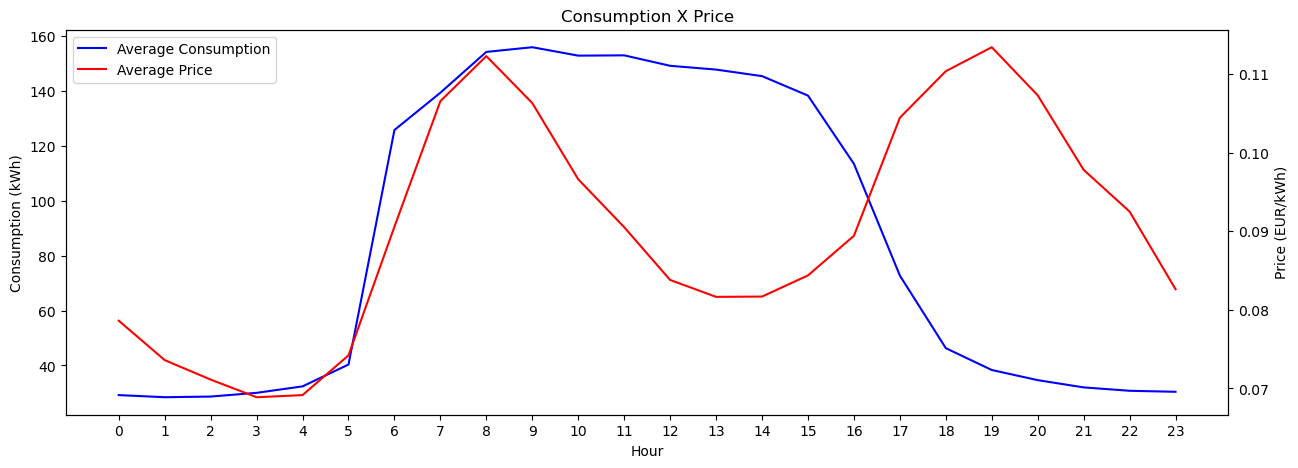

In [6]:
# Increase the width of the plot
plt.figure(figsize=(15, 5))

# Create the first plot for average consumption per hour from Monday to Friday
consumption_plot = plt.plot(average_consumption_weekday["Datetime"], average_consumption_weekday["Consumption"], color='blue', label='Average Consumption')
plt.xlabel('Hour')
plt.ylabel('Consumption (kWh)')
plt.title('Consumption X Price')

# Create the second plot for average price per hour from Monday to Friday
price_plot = plt.twinx()
price_line = plt.plot(average_price_weekday["Datetime"], average_price_weekday["Import Grid (EUR/kWh)"], color='red', label='Average Price')
plt.ylabel('Price (EUR/kWh)')

# Combine the legends for both plots
plots = consumption_plot + price_line
labels = [l.get_label() for l in plots]
plt.legend(plots, labels, loc='upper left')

# Set the tick locations on the x-axis to display all hours
plt.xticks(all_hours)

# Save the figure
plt.savefig('consumption_price_plot.png')

# Save the Graph
plt.savefig('Consumption X Price.png')

# Display the combined plot
plt.show()

### Baterry Calculation

In [7]:
# Calculate the difference between each hour and its previous hour
hourly_diff = average_consumption_weekday['Consumption'].diff()

# Find the index of the peak positive and negative values
peak_positive_index = np.argmax(hourly_diff)

# Get the corresponding hour value
peak_positive_hour = average_consumption_weekday['Datetime'].iloc[peak_positive_index]

# Save the last value before the peak positive hour
last_value_before_peak = average_consumption_weekday['Consumption'].iloc[peak_positive_index - 1]

# Define the peak negative threshold as 50% above the last value before the peak
peak_negative_threshold = last_value_before_peak * 1.1

# Find the hour when the consumption returns to the threshold
peak_negative_hour = average_consumption_weekday.loc[average_consumption_weekday['Consumption'] >= peak_negative_threshold, 'Datetime'].idxmax()

# Format the peak positive and negative hours as time
peak_positive_hour_formatted = datetime.strptime(str(peak_positive_hour), "%H").strftime("%H:%M")
peak_negative_hour_formatted = datetime.strptime(str(peak_negative_hour), "%H").strftime("%H:%M")

# Filter the consumption data between the peak positive and negative hours
peak_consumption = average_consumption_weekday.loc[(average_consumption_weekday['Datetime'] >= peak_positive_hour) & (average_consumption_weekday['Datetime'] < peak_negative_hour), 'Consumption']

# Filter the consumption data out the peak positive and negative hours
off_peak_consumption = average_consumption_weekday.loc[(average_consumption_weekday['Datetime'] >= peak_negative_hour) | (average_consumption_weekday['Datetime'] < peak_positive_hour), 'Consumption']

# Average and Total consumption during peak hours
average_peak_consumption = peak_consumption.mean()
total_peak_consumption = peak_consumption.sum()

# Average and Total consumption outside peak hours
average_off_peak_consumption = off_peak_consumption.mean()
total_off_peak_consumption = off_peak_consumption.sum()

# Filter the price data between the peak positive and negative hours
peak_price = average_price_weekday.loc[(average_price_weekday['Datetime'] >= peak_positive_hour) & (average_price_weekday['Datetime'] < peak_negative_hour), 'Import Grid (EUR/kWh)']

# Filter the price data out the peak positive and negative hours
off_peak_price = average_price_weekday.loc[(average_price_weekday['Datetime'] >= peak_negative_hour) | (average_price_weekday['Datetime'] < peak_positive_hour), 'Import Grid (EUR/kWh)']

# Average, Min, and Max price during peak hours
average_peak_price = peak_price.mean()
max_peak_price = peak_price.max()
min_peak_price = peak_price.min()

# Average, Min, and Max price outside peak hours
average_offpeak_price = off_peak_price.mean()
max_offpeak_price = off_peak_price.max()
min_offpeak_price = off_peak_price.min()

price_diff = peak_price - average_offpeak_price

# Find the consecutive hours with prices higher than the average off-peak price
consecutive_hours = (price_diff > 0).astype(int).cumsum()

# Find the maximum number of consecutive hours with high price
max_consecutive_hours = consecutive_hours.value_counts().idxmax()

# Calculate the total consumption within the longest sequence of hours with high price
total_consumption_highest_sequence = average_peak_consumption * max_consecutive_hours

### Print some information

In [8]:
# Calculate the total consumption within the longest sequence of hours with high price
total_consumption_highest_sequence = average_peak_consumption * max_consecutive_hours

# Print the average peak consumption with two decimal places
print("Average Peak Consumption: {:.2f}".format(average_peak_consumption))
print("Average Off Peak Consumption: {:.2f}".format(average_off_peak_consumption))
print("\n")

# Print the total peak consumption with two decimal places
print("Total Peak Consumption: {:.2f}".format(total_peak_consumption))
print("Total Off Peak Consumption: {:.2f}".format(total_off_peak_consumption))

# Print the peak price with five decimal places
print("Average Peak Price: {:.5f}".format(average_peak_price))
print("Max Peak Price: {:.5f}".format(max_peak_price))
print("Min Peak Price: {:.5f}".format(min_peak_price))
print("\n")

# Print the average off-peak price with five decimal places
print("Average Off Peak Price: {:.5f}".format(average_offpeak_price))
print("Max Off Peak Price: {:.5f}".format(max_offpeak_price))
print("Min Off Peak Price: {:.5f}".format(min_offpeak_price))

# Calculate the rounded total consumption within the highest price sequence
rounded_total_consumption = round(total_consumption_highest_sequence / 5) * 5
if rounded_total_consumption % 10 != 0:
    rounded_total_consumption = round(rounded_total_consumption / 10) * 10

Average Peak Consumption: 137.39
Average Off Peak Consumption: 33.45


Total Peak Consumption: 1648.66
Total Off Peak Consumption: 401.43
Average Peak Price: 0.09403
Max Peak Price: 0.11230
Min Peak Price: 0.08166


Average Off Peak Price: 0.08664
Max Off Peak Price: 0.11343
Min Off Peak Price: 0.06889


In [9]:
# Print the rounded total consumption
print("\nThe Best Battery size is around {:.0f}".format(rounded_total_consumption) + " kW")


The Best Battery size is around 820 kW
